In [1]:
import base64
import os
from enum import Enum
from io import BytesIO
from typing import Iterable
from typing import List
from typing import Literal, Optional

import json

import fitz
# Instructor is powered by Pydantic, which is powered by type hints. Schema validation, prompting is controlled by type annotations
import instructor
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from PIL import Image
from openai import OpenAI
from pydantic import BaseModel, Field

In [2]:
# Function to encode the image as base64
def encode_image(image_path: str):
    # check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


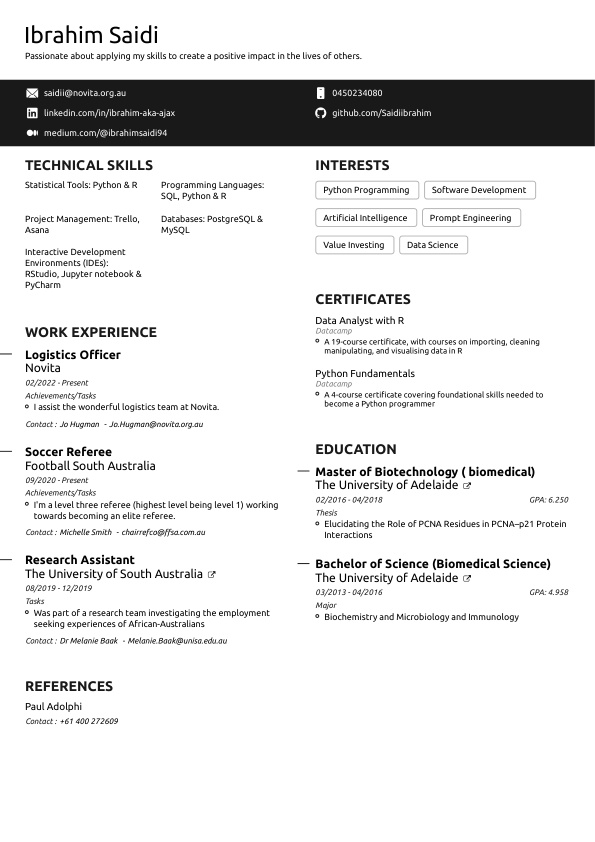

In [3]:
# Function to convert a single page PDF page to a JPEG image
def convert_pdf_page_to_jpg(pdf_path: str, output_path: str, page_number=0):
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"PDF file not found: {pdf_path}")
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # 0 is the first page
    pix = page.get_pixmap()
    # Save the pixmap as a JPEG
    pix.save(output_path)


def display_img_local(image_path: str):
    img = Image.open(image_path)
    display(img)


pdf_path = 'data/Ibrahim_sResume.pdf'
output_path = 'Ibrahim_Resume.jpg'

convert_pdf_page_to_jpg(pdf_path, output_path)
display_img_local(output_path)

In [4]:
base64_img = encode_image(output_path)

class SectionsEnum(str, Enum):
    """Defines possible sections of a resume"""
    About = "About"
    Contact = "Contact"
    Education = "Education"
    Experience = "Experience"
    Skills = "Skills"
    Projects = "Projects"
    Certifications = "Certifications"
    Awards = "Awards"
    References = "References"


class AboutSection(BaseModel):
    """Defines the about section of a resume"""
    name: str = Field(..., description="The name of the person")
    summary: str = Field(..., description="The summary of the person")
    title: Optional[str] = Field(..., description="The title of the person")
    location: Optional[str] = Field(..., description="The location of the person")
    image: Optional[str] = Field(..., description="The image of the person")

class ContactSection(BaseModel):
    """Defines the contact section of a resume"""
    email: str = Field(..., description="The email of the person")
    phone: str = Field(..., description="The phone of the person")
    linkedin: Optional[str] = Field(..., description="The linkedin of the person")
    github: Optional[str] = Field(..., description="The github of the person")
    website: Optional[str] = Field(..., description="The website of the person")


class ExperienceSection(BaseModel):
    """Defines the experience section of a resume"""
    title: str = Field(..., description="The title of the position")
    company: str = Field(..., description="Name of the company")
    location: str = Field(..., description="The location of the company")
    start_date: str = Field(..., description="The start date of the experience")
    end_date: str = Field(..., description="The end date of the experience")
    description: str = Field(..., description="The description of the person")

class EducationSection(BaseModel):
    """Defines the education section of a resume"""
    school: str = Field(..., description="Name of the school")
    degree: str = Field(..., description="Name of the degree")
    location: Optional[str] = Field(..., description="The location of the education")
    start_date: str = Field(..., description="The start date of the education")
    end_date: str = Field(..., description="The end date of the education")
    description: str = Field(..., description="The description of the education")


class CompleteResume(BaseModel):
    """Defines the complete resume"""
    about: AboutSection = Field(..., description="The about section of the resume")
    contact: ContactSection = Field(..., description="The contact section of the resume")
    education: List[EducationSection] = Field(..., description="The education section of the resume")
    experience: List[ExperienceSection] = Field(..., description="The experience section of the resume")


def parse_resume(base64_img: str) -> CompleteResume:
    response = instructor.from_openai(OpenAI()).chat.completions.create(
        model='gpt-4-turbo',
        response_model=CompleteResume,
        messages=[
            {
                "role": "user",
                "content": 'Analyze the given resume and very carefully extract the information.',
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_img}"
                        }
                    },
                ],
            }
        ],
    )
    result = response.model_dump_json()
    # Save the result to disk
    with open("resume_data.json", "w") as file:
        json.dump(result, file)
    return "Resume data extracted successfully!"



In [5]:
result = parse_resume(base64_img)

print(result)



Resume data extracted successfully!


In [9]:
# Read in the saved JSON file
with open("resume_data.json", "r") as file:
    resume_data = json.load(file)

print(resume_data)

{"about":{"name":"Ibrahim Saidi","summary":"Passionate about applying my skills to create a positive impact in the lives of others.","title":"Logistics Officer","location":null,"image":null},"contact":{"email":"saidii@novita.org.au","phone":"0450234080","linkedin":"linkedin.com/in/ibrahim-aka-ajax","github":"github.com/SaidiIbrahim","website":"medium.com/@ibrahimsaidi94"},"education":[{"school":"The University of Adelaide","degree":"Master of Biotechnology (biomedical)","location":"Adelaide","start_date":"07/2016","end_date":"04/2018","description":"Thesis: Elucidating the Role of PCNA Residues in PCNA-p21 Protein Interactions, GPA: 6.250"},{"school":"The University of Adelaide","degree":"Bachelor of Science (Biomedical Science)","location":"Adelaide","start_date":"03/2013","end_date":"04/2016","description":"Major: Biochemistry and Microbiology and Immunology, GPA: 4.958"}],"experience":[{"title":"Logistics Officer","company":"Novita","location":"South Australia","start_date":"02/2022

In [13]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"""You are a helpful assistant tasked with helping users applying for jobs. 
            A user gives you their resume details in the following JSON format: {resume_data}. 
            Given this resume data, please draft a cover letter for an entry level job as a Python developer.
            """,
        }
    ],
    model="gpt-4-turbo",
)

In [14]:
print(chat_completion.choices[0].message.content)



[Your Address]  
[City, State, Zip]  
[Date]

[Recipient Name]  
[Hiring Manager]  
[Company Name]  
[Company Address]  
[City, State, Zip]

Dear [Recipient Name],

I am writing to express my interest in the entry-level Python Developer position at [Company Name], as advertised. With a strong background in science and research combined with my recently acquired programming skills, I am eager to contribute to your team by offering innovative software solutions.

I have an educational foundation with a Master of Biotechnology and a Bachelor of Science in Biomedical Science from the University of Adelaide. During my studies, I focused extensively on detailed research and data analysis, which required precision, patience, and persistence. These experiences honed my analytical thinking and problem-solving skills, which are vital for a successful career in software development.

My journey into Python began out of my personal interest in automating mundane tasks and analyzing data more effec

In [5]:
# call the functions to analyze the organizational chart and parse the response
# result = parse_resume(base64_img)

# # Extract the data in JSON format
# json_data = result.model_dump_json()



# # Print the JSON data
# print(json_data)



{"about":{"name":"Ibrahim Saidi","summary":"Passionate about applying my skills to create a positive impact in the lives of others.","title":"Logistics Officer","location":null,"image":null},"contact":{"email":"saidii@novita.org.au","phone":"0450234080","linkedin":"linkedin.com/in/ibrahim-aka-ajax","github":"github.com/SaidiIbrahim","website":"medium.com/@ibrahimsaidi94"},"education":[{"school":"The University of Adelaide","degree":"Master of Biotechnology (biomedical)","location":"The University of Adelaide","start_date":"07/2016","end_date":"04/2018","description":"Thesis: Elucidating the Role of PCNA Residues in PCNA-p21 Protein Interactions. GPA: 6.250"},{"school":"The University of Adelaide","degree":"Bachelor of Science (Biomedical Science)","location":"The University of Adelaide","start_date":"03/2013","end_date":"04/2016","description":"Major: Biochemistry and Microbiology and Immunology. GPA: 4.958"}],"experience":[{"title":"Logistics Officer","company":"Novita","location":"No

In [6]:
# Format the data
# formatted_data = json.dumps(json_data, indent=2)

# print(formatted_data)

"{\"about\":{\"name\":\"Ibrahim Saidi\",\"summary\":\"Passionate about applying my skills to create a positive impact in the lives of others.\",\"title\":\"Logistics Officer\",\"location\":null,\"image\":null},\"contact\":{\"email\":\"saidii@novita.org.au\",\"phone\":\"0450234080\",\"linkedin\":\"linkedin.com/in/ibrahim-aka-ajax\",\"github\":\"github.com/SaidiIbrahim\",\"website\":\"medium.com/@ibrahimsaidi94\"},\"education\":[{\"school\":\"The University of Adelaide\",\"degree\":\"Master of Biotechnology (biomedical)\",\"location\":\"The University of Adelaide\",\"start_date\":\"07/2016\",\"end_date\":\"04/2018\",\"description\":\"Thesis: Elucidating the Role of PCNA Residues in PCNA-p21 Protein Interactions. GPA: 6.250\"},{\"school\":\"The University of Adelaide\",\"degree\":\"Bachelor of Science (Biomedical Science)\",\"location\":\"The University of Adelaide\",\"start_date\":\"03/2013\",\"end_date\":\"04/2016\",\"description\":\"Major: Biochemistry and Microbiology and Immunology. 

In [7]:

# Store the JSON data in a file
# with open("resume_data.json", "w") as file:
#     json.dump(json_data, file)

# print("Data stored successfully!")

Data stored successfully!
